## Fits files and simple gauss fitting 

In this tutorial we will try to fit a single line of a spectrum, using a very general fitting approach. The approach presented should not be used in actual research. It is only used to demonstration!

In [1]:
import numpy as np
from matplotlib import pylab as plt
from astropy.io import fits

First we define the path to our fits file.

In [2]:
path = "seminar7/"
name = "151130.fits"

we can open the file using the open function of fits.io.

In [3]:
FITS = fits.open(path+name) 

In [4]:
HEAD = FITS[0].header

We can print the entire header by calling it. 

In [5]:
HEAD

 [astropy.io.fits.verify]


SIMPLE  =                    T / Fits standard                                  
BITPIX  =                  -32 / Bits per pixel                                 
NAXIS   =                    1 / Number of axes                                 
NAXIS1  =                 1995 / Axis length                                    
EXTEND  =                    T / File may contain extensions                    
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        
DATE    = '2016-05-14T05:56:17' / Date FITS file was generated                  
IRAF-TLM= '2016-05-14T05:56:13' / Time of last modification                     
OBJECT  = 'V409Tau '           / Name of the object observed                    
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
EXPTIME =                3600. / duration of exposure in seconds                
XBINNING=                   

We can extract individual arguments of the header by simply calling them.

In [6]:
Central_Wavelength = FITS[0].header["CENTWAVE"]
print Central_Wavelength

6500


We can also extract the data as follows. Fortunately astropy.io will directly output multi dimensional datasets as numpy arrays. In this case the data consits of a one dimensional spectum.

In [7]:
DATA = FITS[0].data

We can quickly visualise the data:

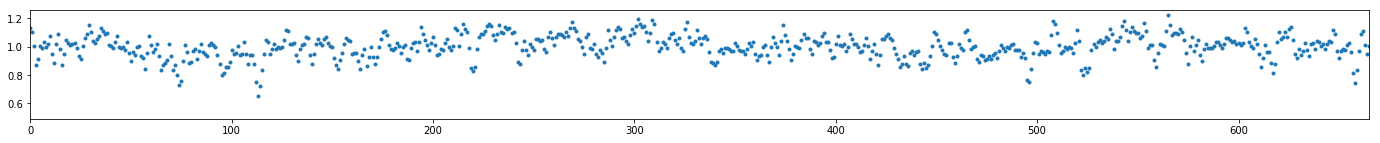

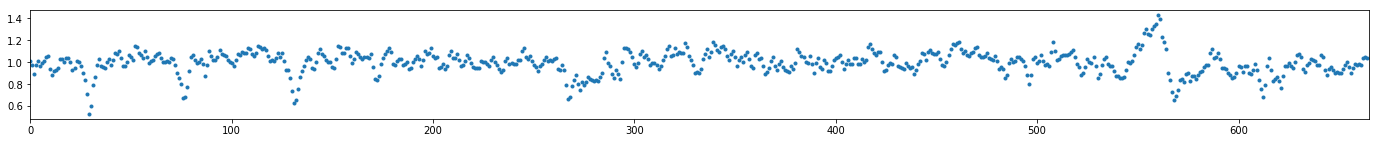

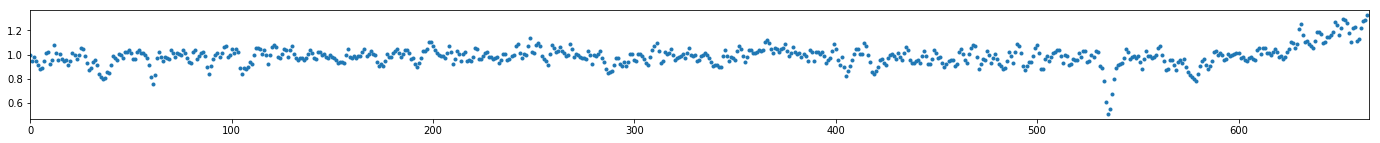

In [8]:
plt.figure(figsize = (24,2))
plt.plot(DATA[:DATA.shape[0]/2], ".")
plt.xlim(0,DATA.shape[0]/3)
plt.show()

plt.figure(figsize = (24,2))
plt.plot(DATA[DATA.shape[0]/3:DATA.shape[0]*2/3], ".")
plt.xlim(0,DATA.shape[0]/3)
plt.show()

plt.figure(figsize = (24,2))
plt.plot(DATA[DATA.shape[0]*2/3:], ".")
plt.xlim(0,DATA.shape[0]/3)
plt.show()

We can compute the signal to noise ratio (SN) by deviting the mean with the standart diviation as follows:

In [9]:
SN  = DATA.astype("float").mean()/DATA.astype("float").std()
print SN


11.1373010739


In our case, we want to focus on the H-alpha line, which is the strongest line in the spectrum. We first have to locate the line and than try to fit it and determine its shape according to Bouvier et. al. 2003.

Let`s first try to find the line maually by identifying it in the plot above.

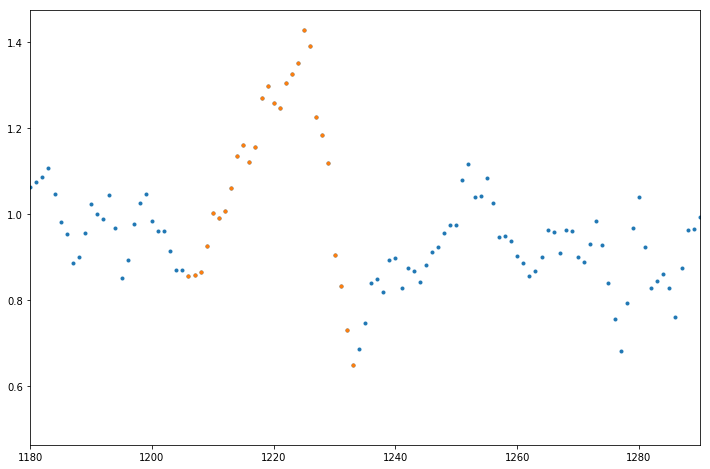

In [10]:
lim0, lim1 = 1206, 1234
DATAY = DATA[lim0:lim1]
DATAX = np.arange(DATA.shape[0])[lim0:lim1]

plt.figure(figsize = (12,8))
plt.plot(np.arange(DATA.shape[0]), DATA , ".")
plt.plot(DATAX                   , DATAY, ".")

plt.xlim(1180,1290)
plt.show()

Now we have extracted the data, which we subjectively asociate with the H-alpha line from the dataset.

## Gauss Fit

Before we go on, lets generate a few simple data points to fit them. First, we define the gauss function.

$f(x)=Ae^{-\frac{(x-b)^2}{2\sigma}^2}+C$

In [11]:
def gauss_f(x, A=1., b=0., sigma=1., C = 0. ):
    y = A*np.exp(-(x-b)**2/(2.*sigma**2))+C
    return y

Next we define a one dimensional space X on which we will generate a gauss distribution Y for a variety of parameters.

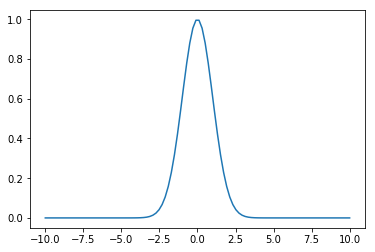

In [12]:
X   = np.linspace(-10,10,100)
Y   = gauss_f(X)
plt.plot(X,Y)
plt.show()

Next, we can generate a 3D array of possible parameter permutations. The size of the array depends on the number of parameters, the number of parameter variations and the fact, that we only change one parameter per sub figure.

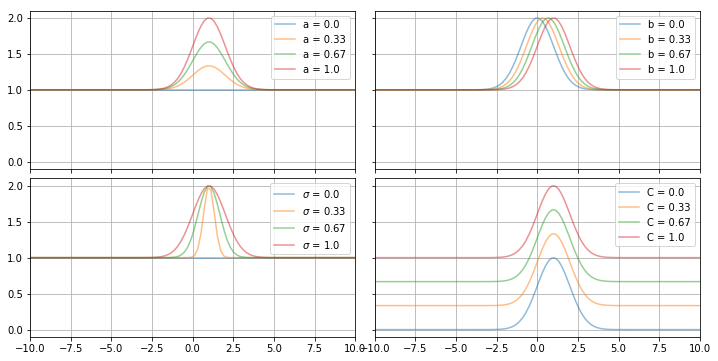

In [13]:

a = (np.linspace(0.00001,1.,4)*np.ones((4,4)).T).T
Z = np.ones((a.shape[0],a.shape[1],4))
for i in range(Z.shape[2]):
    Z[i,:,i] = a[:,i]


def plot_samples(X,Z, nrow=2, ncol=2):
    
    lab = ["a","b",r"$\sigma$","C"]
    
    fig, axs = plt.subplots(nrows=nrow, ncols=ncol,figsize = (ncol*6,nrow*3), frameon = False, sharex=True, sharey = True)
    for i in range(nrow*ncol):
        
        axes = axs.reshape(-1)
        for j in range(Z.shape[1]):
            axes[i].plot(X,gauss_f(X,*Z[i,j]),"-", label = str(lab[i])+" = "+str(round(Z[i,j,i],2)), alpha = 0.5 )

        axes[i].set_xlim([X[0],X[-1]])
        axes[i].grid()
        axes[i].legend()
    
    fig.subplots_adjust(hspace=0.06)
    fig.subplots_adjust(wspace=0.06)
    plt.show()
plot_samples(X,Z, nrow=2, ncol=2)

Next, we will use the curve_fit function of scipy.optimize to produce a simple fit.

In [14]:
from scipy.optimize import curve_fit

**variable** presents the optimal values for the parameters so that the sum of the squared residuals of f(X, *args) - Y is minimized.

**error** presents the estimated covariance of popt. The diagonals provide the variance of the parameter estimate. To compute one standard deviation errors on the parameters use perr = np.sqrt(np.diag(pcov)).

In [15]:
variable, error = curve_fit(gauss_f, X,Y)

In [16]:
variable

array([  1.00000000e+00,  -2.47395877e-09,   1.00000000e+00,
         1.13772240e-11])

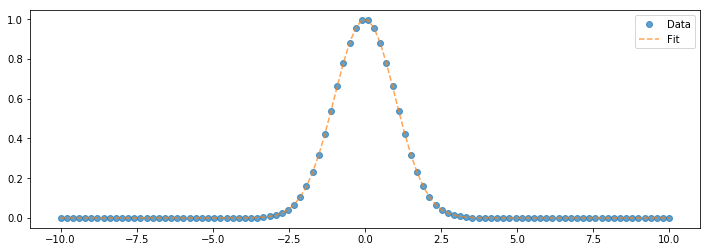

A , b, sigma
[  1.00000000e+00  -2.47395877e-09   1.00000000e+00   1.13772240e-11]


In [17]:
Yv = gauss_f(X,*variable)
def simple_plot(X,Y,Yv):

    plt.figure(figsize = (12,4))
        ### plot data
    plt.plot(X,Y                   , "o", alpha = 0.7, label="Data") 
    ### plot fit
    plt.plot(X,Yv,"--", alpha = 0.7, label="Fit")
    plt.legend()
    plt.show()
simple_plot(X,Y,Yv)
print "A , b, sigma"
print variable

Next we will introduce some noise in Y. and plot the result

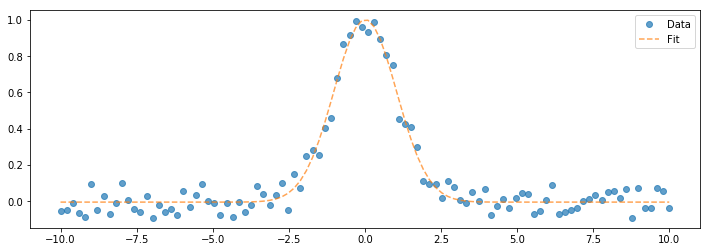

A , b, sigma
[ 1.00626037  0.01077229  1.03009454 -0.00420222]


In [18]:
YN              = Y+(np.random.rand(Y.shape[0])-0.5)/5.
variable, error = curve_fit(gauss_f, X,YN)
YNv             = gauss_f(X,*variable)
simple_plot(X,YN,YNv)
print "A , b, sigma"
print variable

From here we can create more complicated functions. 

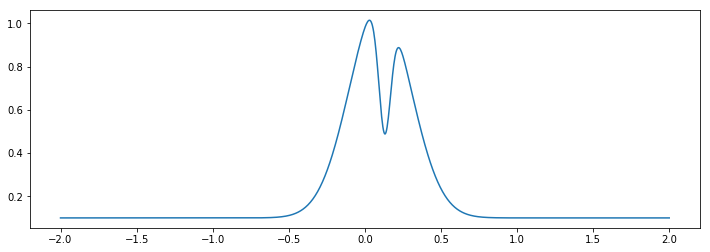

In [19]:
def gauss_2(x, A1=1., b1=0.1, sigma1=0.2, A2=-0.6, b2=0.13, sigma2=0.04, C = 0.1):
    y = A1*np.exp(-(x-b1)**2/(2.*sigma1**2))+A2*np.exp(-(x-b2)**2/(2.*sigma2**2))+C
    return y
X1 = np.linspace(-2,2,1000)
Y1 = gauss_2(X1)

plt.figure(figsize = (12,4))
plt.plot(X1,Y1)
plt.show()

Let`s try to fit the previous function to our data. The data being [DATAX, DATAY].

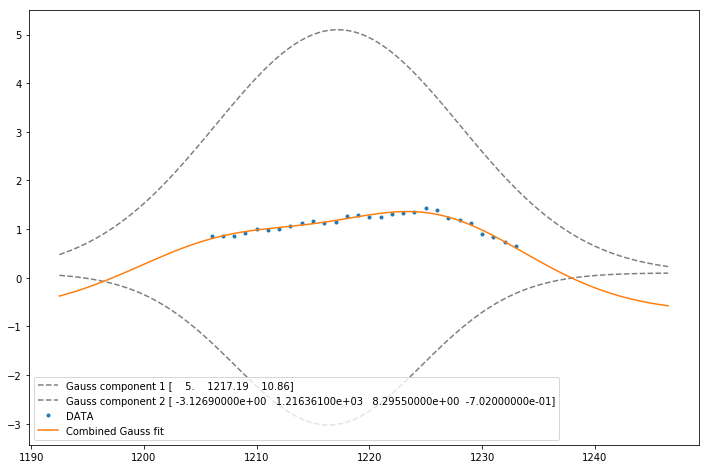

In [20]:
variable, error = curve_fit(gauss_2, DATAX,DATAY,
                            p0 = [4., 1220., 3., 1.1, 1232., 3., 1.0], 
                            bounds = ([1. , 1200., 0.01  , -20. , 1200., 0.01  , -5],
                                      [5., 1240., 100.,   2. , 1280., 100., 5]),
                            method= "dogbox", 
                            maxfev=100000)


### defines the space in which we generate the fit function
lenDATAX        = (DATAX[-1]-DATAX[0])/2.
XN              = np.linspace(DATAX[0]-lenDATAX, DATAX[-1]+lenDATAX, 100 ) 
### computes a curve based on the generated fitting parameters.
YNv             = gauss_2(XN,*variable)

### generates the two individual components of our fitting function.  
G1 = gauss_2(XN,*variable[:3])
G2 = gauss_2(XN,*variable[3:])

### plotting
plt.figure(figsize = (12,8))
plt.plot(XN    , G1  , 
         "--k", 
         alpha = 0.5, 
         label = "Gauss component 1 "+str(np.round(variable[:3],2) ) )

plt.plot(XN    , G2  , 
         "--k", alpha = 0.5, 
         label = "Gauss component 2 "+str(np.round(variable[3:],4) ) )

plt.plot(DATAX , DATAY, ".", label = "DATA")
plt.plot(XN    , YNv  , "-", label = "Combined Gauss fit")
plt.legend(loc = "lower left")
#plt.xlim(1180,1290)
plt.show()

From the plot we can identify the short comings of our analysis:
    - not enough data points
    - S/N too low
    - insufficient complexity of our self-generated fitting function.
    

#### All in all, this data is not good enough to be fitted!

We will further analyse the spectrum next week, using some higher level functions. In preparation for next week, you can check out the following links:

- http://docs.sunpy.org/en/stable/code_ref/map.html
- https://github.com/astropy/specutils
- https://python4astronomers.github.io/fitting/spectrum.html
- http://docs.astropy.org/en/stable/modeling/
- http://hea-www.harvard.edu/~aldcroft/tmp/p4a/hamogu/html/astropy-UVES/UVES.html
- http://www.sdss.org/dr13/manga/manga-tutorials/how-do-i-look-at-my-data/python/